In [10]:
import matplotlib.pyplot as plt
import tacoma as tc
import os
import contact_networks as cn
import numpy as np
from scipy import stats
from matplotlib.lines import Line2D
import networkx as nx
import csv

(24, 60, 60)


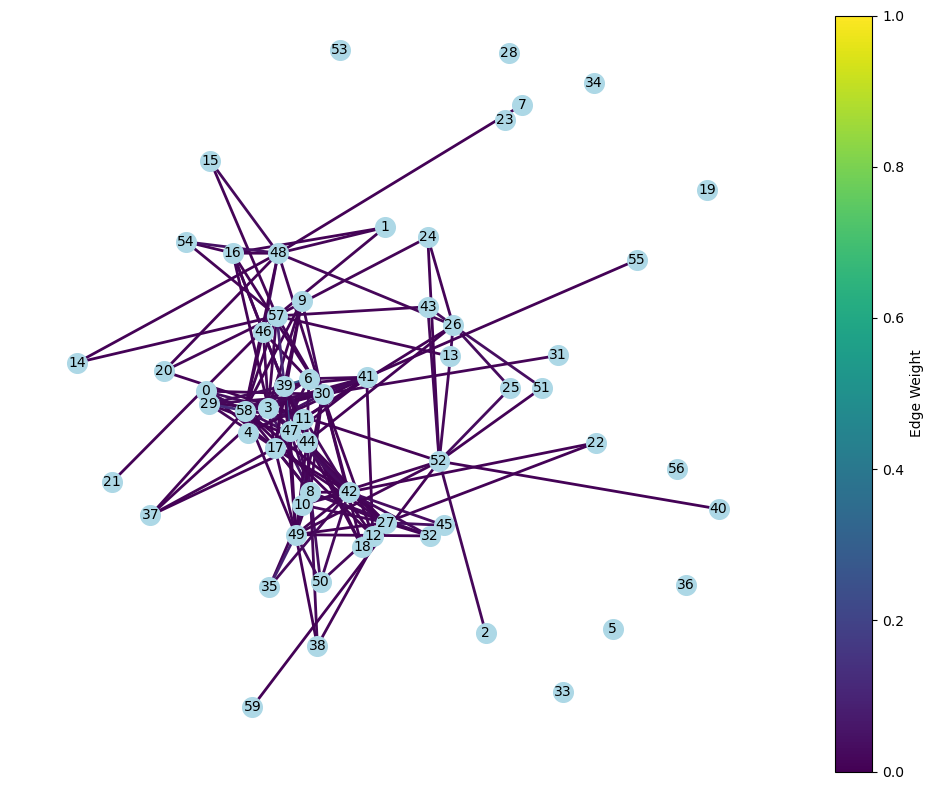

In [9]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Load the numpy array and scale it
A_all = np.load('./24h_networks/primaryschool_60_60.npy')
A = A_all[12]

# Create a weighted undirected graph from index 10
G = nx.from_numpy_array(A)

# Threshold for edge weights (adjust as needed)
threshold = 0  # Example threshold value

# Remove edges below the threshold
edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < threshold]
G.remove_edges_from(edges_to_remove)

# Compute a layout based on edge weights for positioning of nodes
pos = nx.spring_layout(G, weight='weight')

# Create a colormap for edges based on weights
edge_colors = [plt.cm.viridis(Normalize(vmin=min(A.flatten()), vmax=max(A.flatten()))(weight)) for u, v, weight in G.edges(data='weight')]

# Plot the graph
plt.figure(figsize=(10, 8))

# Draw edges with customized colors and widths based on weights
edges = nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2.0, edge_cmap=plt.cm.viridis, edge_vmin=min(A.flatten()), edge_vmax=max(A.flatten()))

# Draw nodes and labels
nodes = nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=200)
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

# Set title and colorbar
plt.colorbar(edges, label="Edge Weight")

# Remove axis for cleaner visualization
plt.axis('off')

plt.tight_layout()

print(A_all.shape)

In [14]:
# Example numpy array with shape (T, N, N)
T, N = 3, 4
array = np.random.rand(T, N, N)

# Function to export numpy array to CSV
def export_to_csv(array, filename='output.csv'):
    T, N, _ = array.shape
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Write the header
        writer.writerow(['t', 'i', 'j', 'value'])
        # Write the data
        for t in range(T):
            for i in range(N):
                for j in range(N):
                    writer.writerow([t, i, j, array[t, i, j]])

# Export the array to CSV
for file in os.listdir('24h_networks'):
    A_all = np.load('24h_networks/' + file)
    export_file = '24h_networks_csv/' + file.split('.')[0] + '.csv'
    export_to_csv(A_all, export_file)

(array([9.938e+03, 3.600e+01, 1.200e+01, 6.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 4.000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

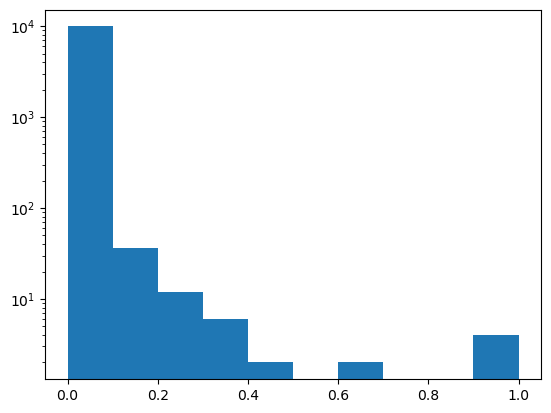

In [72]:
# Load the numpy array and scale it
A = np.load('./24h_networks/highschoole_100_100.npy')[10]
plt.hist(A.flatten(), log=True)

In [2]:
def get_networks(ntype, method='STEPS_pareto'):
    # Find model network
    path_mod = f'./networks/{ntype}/medians/'
    files_in_directory = os.listdir(path_mod)
    matching_file = [f for f in files_in_directory if method in f and '.taco' in f][0]
    tn_mod = tc.load_json_taco(path_mod + matching_file)

    # Empirical network
    tn_emp = tc.load_json_taco(f'./networks/{ntype}/empirical.taco')

    return tn_emp, tn_mod

In [13]:
tn_emp, tn_mod = get_networks('office')

gamma = 20 / (7*24*60*60)

# PS = 0.0006, 0.002
# SU = .03, .11
# HS = .0025, .009
# OF = .005, .025
betas = np.linspace(0.0025, 0.009, 7)
#I_mods_HS = [np.mean(cn.run_SIR(tn_mod, None, 'STEPS_pareto', 250, beta, gamma, 35, normalize=False, save=False, plot=False, save_path=False), axis=0) / tn_emp.N for beta in betas]
#I_emps_HS = [np.mean(cn.run_SIR(tn_emp, None, 'STEPS_pareto', 250, beta, gamma, 35, normalize=False, save=False, plot=False, save_path=False), axis=0) / tn_emp.N for beta in betas]

beta = 0.03
I = np.mean(cn.run_SIR(tn_emp, None, 'STEPS_pareto', 250, beta, gamma, 35, normalize=False, save=False, plot=False, save_path=False), axis=0) / tn_emp.N
np.max(I)

0.03


  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [00:16<00:00, 15.11it/s]


0.3445529953917051

In [14]:
def compute_SIR_various_betas(ntype, gamma_d=7, method='STEPS_pareto', save=True):
    gamma = 20 / (gamma_d*24*60*60)  # convert to gamma in 20sec TU
    tn_emp, tn_mod = get_networks(ntype)

    if ntype == 'highschool':
        beta_min, beta_max =  .0025, .009
    elif ntype == 'primaryschool':
        beta_min, beta_max =  0.0006, 0.002
    elif ntype == 'supermarked':
        beta_min, beta_max =  .03, .11
    elif ntype == 'office':
        beta_min, beta_max = .005, .03
    
    betas = np.linspace(beta_min, beta_max, 7)
    
    I_mods = [np.mean(cn.run_SIR(tn_mod, None, method, 250, beta, gamma, 35, normalize=False, save=False, plot=False, save_path=False), axis=0) / tn_emp.N for beta in betas]
    I_emps = [np.mean(cn.run_SIR(tn_emp, None, method, 250, beta, gamma, 35, normalize=False, save=False, plot=False, save_path=False), axis=0) / tn_emp.N for beta in betas]

    if save:
        np.save(f'./beta_variation/STEPS_{ntype}_{gamma_d}_emp.npy', I_emps)
        np.save(f'./beta_variation/STEPS_{ntype}_{gamma_d}_mod.npy', I_mods)
    
    return I_mods, I_emps

for gamma in [4, 7, 10]:
    for ntype in ['office']:
        I_mods_HS, I_emps_HS = compute_SIR_various_betas(ntype, gamma_d=gamma, save=True)

0.005


  1%|          | 2/250 [00:00<00:13, 17.77it/s]

100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


0.009166666666666667


100%|██████████| 250/250 [00:15<00:00, 16.10it/s]


0.013333333333333332


100%|██████████| 250/250 [00:15<00:00, 15.82it/s]


0.0175


100%|██████████| 250/250 [00:15<00:00, 16.19it/s]


0.021666666666666667


100%|██████████| 250/250 [00:14<00:00, 16.92it/s]


0.025833333333333333


100%|██████████| 250/250 [00:14<00:00, 17.06it/s]


0.03


100%|██████████| 250/250 [00:15<00:00, 16.63it/s]


0.005


100%|██████████| 250/250 [00:08<00:00, 29.17it/s]


0.009166666666666667


100%|██████████| 250/250 [00:10<00:00, 23.55it/s]


0.013333333333333332


100%|██████████| 250/250 [00:10<00:00, 22.80it/s]


0.0175


100%|██████████| 250/250 [00:10<00:00, 23.23it/s]


0.021666666666666667


100%|██████████| 250/250 [00:11<00:00, 22.25it/s]


0.025833333333333333


100%|██████████| 250/250 [00:11<00:00, 21.33it/s]


0.03


100%|██████████| 250/250 [00:10<00:00, 24.04it/s]


0.005


100%|██████████| 250/250 [00:17<00:00, 14.51it/s]


0.009166666666666667


100%|██████████| 250/250 [00:18<00:00, 13.25it/s]


0.013333333333333332


100%|██████████| 250/250 [00:19<00:00, 13.02it/s]


0.0175


100%|██████████| 250/250 [00:20<00:00, 12.30it/s]


0.021666666666666667


100%|██████████| 250/250 [00:20<00:00, 11.94it/s]


0.025833333333333333


100%|██████████| 250/250 [00:19<00:00, 12.71it/s]


0.03


100%|██████████| 250/250 [00:19<00:00, 12.71it/s]


0.005


100%|██████████| 250/250 [00:10<00:00, 23.47it/s]


0.009166666666666667


100%|██████████| 250/250 [00:15<00:00, 16.60it/s]


0.013333333333333332


100%|██████████| 250/250 [00:15<00:00, 16.60it/s]


0.0175


100%|██████████| 250/250 [00:14<00:00, 16.95it/s]


0.021666666666666667


100%|██████████| 250/250 [00:15<00:00, 15.95it/s]


0.025833333333333333


100%|██████████| 250/250 [00:15<00:00, 16.40it/s]


0.03


100%|██████████| 250/250 [00:16<00:00, 14.96it/s]


0.005


100%|██████████| 250/250 [00:18<00:00, 13.38it/s]


0.009166666666666667


100%|██████████| 250/250 [00:20<00:00, 12.31it/s]


0.013333333333333332


100%|██████████| 250/250 [00:20<00:00, 12.48it/s]


0.0175


100%|██████████| 250/250 [00:20<00:00, 12.20it/s]


0.021666666666666667


100%|██████████| 250/250 [00:20<00:00, 12.26it/s]


0.025833333333333333


100%|██████████| 250/250 [00:20<00:00, 12.41it/s]


0.03


100%|██████████| 250/250 [00:20<00:00, 12.21it/s]


0.005


100%|██████████| 250/250 [00:13<00:00, 18.14it/s]


0.009166666666666667


100%|██████████| 250/250 [00:15<00:00, 15.93it/s]


0.013333333333333332


100%|██████████| 250/250 [00:16<00:00, 15.59it/s]


0.0175


100%|██████████| 250/250 [00:16<00:00, 14.97it/s]


0.021666666666666667


100%|██████████| 250/250 [00:16<00:00, 14.95it/s]


0.025833333333333333


100%|██████████| 250/250 [00:16<00:00, 15.56it/s]


0.03


100%|██████████| 250/250 [00:16<00:00, 15.54it/s]


In [7]:
I_mods_PS, I_emps_PS = compute_SIR_various_betas('primaryschool', gamma_d=4, save=False)

0.0006


100%|██████████| 250/250 [00:13<00:00, 18.27it/s]


0.0008333333333333333


100%|██████████| 250/250 [00:17<00:00, 14.52it/s]


0.0010666666666666667


100%|██████████| 250/250 [00:24<00:00, 10.21it/s]


0.0013


100%|██████████| 250/250 [00:26<00:00,  9.42it/s]


0.0015333333333333334


100%|██████████| 250/250 [00:29<00:00,  8.45it/s]


0.0017666666666666668


100%|██████████| 250/250 [00:33<00:00,  7.51it/s]


0.002


100%|██████████| 250/250 [00:32<00:00,  7.78it/s]


0.0006


100%|██████████| 250/250 [00:19<00:00, 12.70it/s]


0.0008333333333333333


100%|██████████| 250/250 [00:30<00:00,  8.12it/s]


0.0010666666666666667


100%|██████████| 250/250 [00:39<00:00,  6.30it/s]


0.0013


100%|██████████| 250/250 [00:44<00:00,  5.63it/s]


0.0015333333333333334


100%|██████████| 250/250 [00:48<00:00,  5.17it/s]


0.0017666666666666668


100%|██████████| 250/250 [00:47<00:00,  5.22it/s]


0.002


100%|██████████| 250/250 [00:44<00:00,  5.63it/s]


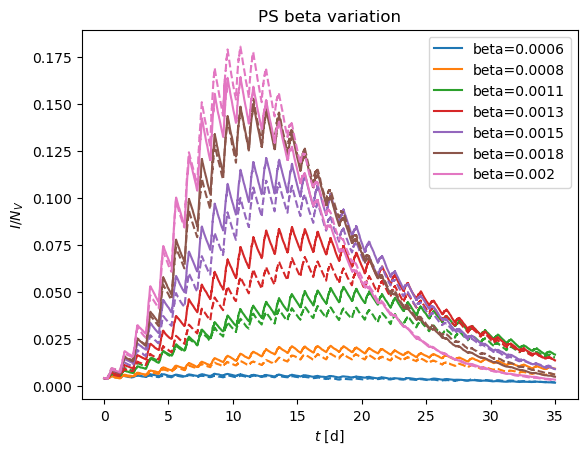

In [9]:
def plot_beta_variations(I_mods, I_emps, ntype):
    if ntype == 'HS':
        beta_min, beta_max =  .0025, .009
    elif ntype == 'PS':
        beta_min, beta_max =  0.0006, 0.002
    elif ntype == 'SU':
        beta_min, beta_max =  .03, .11
    
    betas = np.linspace(beta_min, beta_max, 7)
    t_emp = np.arange(0, len(I_emps[0]), 1) * 20/(24*60**2)
    t_mod = np.arange(0, len(I_mods[0]), 1) * 20/(24*60**2)
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']
    for I_emp, I_mod, beta, c in zip(I_emps, I_mods, betas, colors):
        plt.plot(t_emp, I_emp, label=f'beta={round(beta, 4)}', color=c)
        plt.plot(t_mod, I_mod, color=c, linestyle='--')

    plt.legend()
    plt.xlabel(r'$t$ [d]')
    plt.ylabel(r'$I/N_V$')
    plt.title(f'{ntype} beta variation')

plot_beta_variations(I_mods_PS, I_emps_PS, 'PS')

In [109]:
np.save('./beta_variation/STEPS_PS_mod.npy', np.array(I_mods_PS)[:-1])
np.save('./beta_variation/STEPS_PS_emp.npy', np.array(I_emps_PS)[:-1])

In [15]:
.18 + 2 * .07

0.32

highschool - Sample mean: 0.49428571428571433
highschool - t-statistic: 0.0
highschool - p-value: 1.0
highschool - Sample mean: 0.49428571428571433
highschool - t-statistic: 0.0
highschool - p-value: 1.0
highschool - Sample mean: 0.6057142857142856
highschool - t-statistic: 0.0
highschool - p-value: 1.0
primaryschool - Sample mean: 0.4985714285714286
primaryschool - t-statistic: 0.0
primaryschool - p-value: 1.0
primaryschool - Sample mean: 0.4985714285714286
primaryschool - t-statistic: 0.0
primaryschool - p-value: 1.0
primaryschool - Sample mean: 0.37142857142857144
primaryschool - t-statistic: 0.0
primaryschool - p-value: 1.0
supermarked - Sample mean: 1.1614285714285715
supermarked - t-statistic: 0.0
supermarked - p-value: 1.0
supermarked - Sample mean: 1.3742857142857143
supermarked - t-statistic: 0.0
supermarked - p-value: 1.0
supermarked - Sample mean: 1.34
supermarked - t-statistic: 0.0
supermarked - p-value: 1.0
office - Sample mean: 1.3185714285714287
office - t-statistic: 0.0

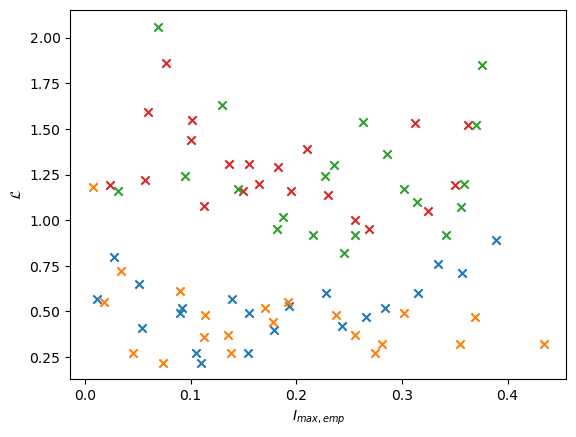

In [17]:
def retrieve_betas(ntype):
    if ntype == 'primaryschool':
        betas = np.linspace(0.0006, 0.002, 7)
    elif ntype == 'supermarked':
        betas = np.linspace(.03, .11, 7)
    elif ntype == 'highschool':
        betas = np.linspace(.0025, .009, 7)
    elif ntype == 'office':
        betas = np.linspace(.005, .03, 7)
    
    return betas


def plot_SIR_variation(ntype):
    betas = retrieve_betas(ntype)
    I_emps = np.load(f'./beta_variation/STEPS_{ntype}_emp.npy')
    I_mods = np.load(f'./beta_variation/STEPS_{ntype}_mod.npy')

    t_emp = np.arange(0, len(I_emps[0]), 1) * 20/(24*60**2)
    t_mod = np.arange(0, len(I_mods[0]), 1) * 20/(24*60**2)
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']
    for I_emp, I_mod, beta, c in zip(I_emps, I_mods, betas, colors):
        plt.plot(t_emp, I_emp, label=f'beta={round(beta, 4)}', color=c)
        plt.plot(t_mod, I_mod, color=c, linestyle='--')
    plt.legend()


def plot_cost_variation():
    #fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    for ntype, c, err in zip(['highschool', 'primaryschool', 'supermarked', 'office'], ['tab:blue', 'tab:orange', 'tab:red', 'tab:green'], [.12,.22, .9, .32]):
        for gamma, marker in zip([7, 4, 10], ['x', 'x', 'x']):
            betas = retrieve_betas(ntype)
            I_emps = np.load(f'./beta_variation/STEPS_{ntype}_{gamma}_emp.npy')
            I_mods = np.load(f'./beta_variation/STEPS_{ntype}_{gamma}_mod.npy')
            time = np.arange(0, len(I_emps[0]), 1) * 20/(24*60**2)

            costs = []
            label=ntype + f' gamma={gamma}'

            for I_mod, I_emp in zip(I_mods, I_emps):
                time_diff = abs(round((time[np.argmax(I_emp)] - time[np.argmax(I_mod)])/time[np.argmax(I_emp)], 2))
                size_diff = abs(round((np.max(I_emp) - np.max(I_mod)), 2))
                #axs[0].scatter(np.max(I_emp), time_diff, color=c, marker='x')
                #axs[1].scatter(np.max(I_emp), size_diff, color=c, marker='x')
                cost = 5*size_diff + 3*time_diff + err
                costs.append(cost)
                plt.scatter(np.max(I_emp), cost, color=c, marker=marker, label=label)
                label=None

            # Statistical analysis on costs for the current ntype
            sample_mean = np.mean(costs)
            t_statistic, p_value = stats.ttest_1samp(costs, sample_mean)

            # Print the results for the current ntype
            print(f"{ntype} - Sample mean: {sample_mean}")
            print(f"{ntype} - t-statistic: {t_statistic}")
            print(f"{ntype} - p-value: {p_value}")
        #plt.legend()
        plt.xlabel(r'$I_{max, emp}$')
        plt.ylabel(r'$\mathcal{L}$')

plot_cost_variation()

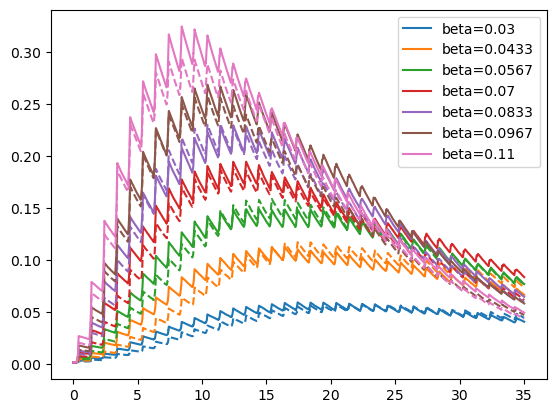

In [129]:
plot_SIR_variation('SU')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


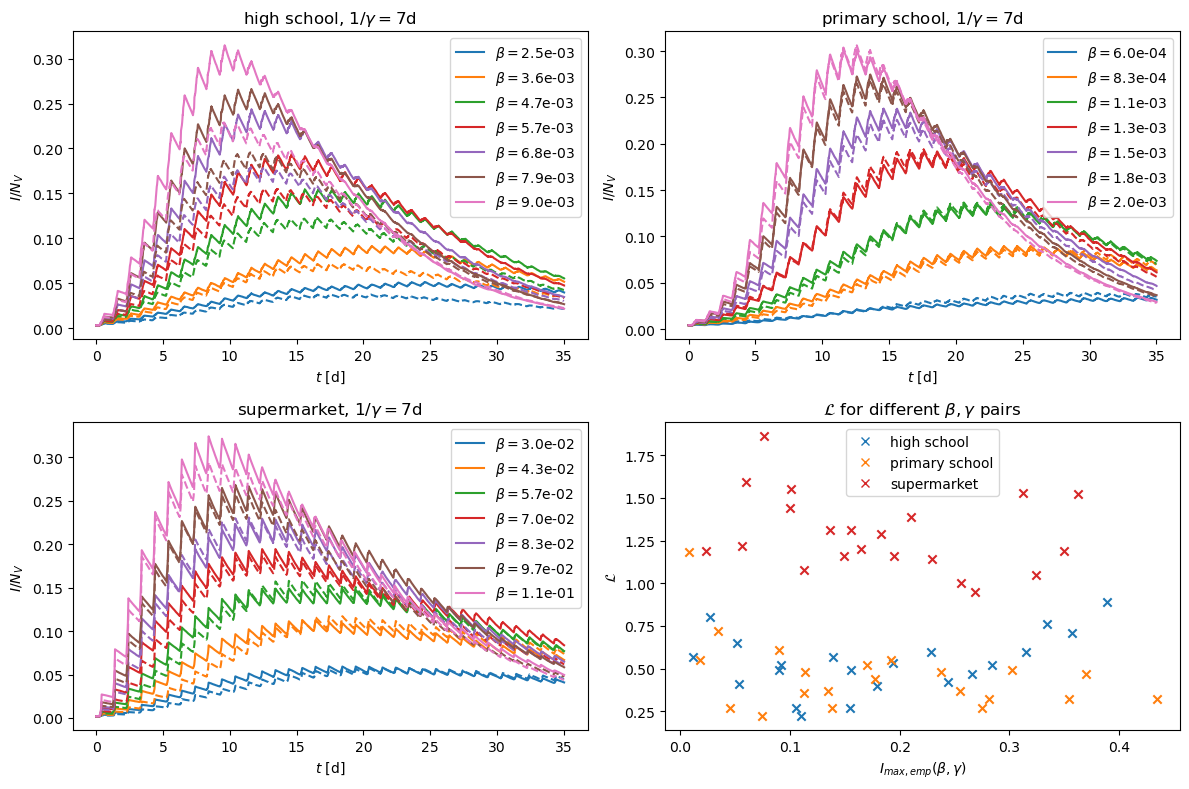

In [28]:
def all_together():
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    (ax1, ax2, ax3, ax4) = axs.flatten()
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']
    for ntype, c_net, err, ax in zip(['highschool', 'primaryschool', 'supermarked'], ['tab:blue', 'tab:orange', 'tab:red'], [.12,.22, .9], axs.flatten()[:-1]):
        for gamma in [4, 7, 10]:
            betas = retrieve_betas(ntype)
            I_emps = np.load(f'./beta_variation/STEPS_{ntype}_{gamma}_emp.npy')
            I_mods = np.load(f'./beta_variation/STEPS_{ntype}_{gamma}_mod.npy')
            time = np.arange(0, len(I_emps[0]), 1) * 20/(24*60**2)

            costs = []
            label=ntype

            t_emp = np.arange(0, len(I_emps[0]), 1) * 20/(24*60**2)
            t_mod = np.arange(0, len(I_mods[0]), 1) * 20/(24*60**2)

            if ntype == 'supermarked':
                title = 'supermarket'
            elif ntype == 'primaryschool':
                title = 'primary school'
            elif ntype == 'highschool':
                title = 'high school'
            else:
                title = ntype
            title += r', $1/\gamma=7$d'
            ax.set(xlabel=r'$t$ [d]', ylabel=r'$I/N_V$', title=title)
            for I_mod, I_emp, c, beta in zip(I_mods, I_emps, colors, betas):
                time_diff = abs(round((time[np.argmax(I_emp)] - time[np.argmax(I_mod)])/time[np.argmax(I_emp)], 2))
                size_diff = abs(round((np.max(I_emp) - np.max(I_mod)), 2))
                cost = 5*size_diff + 3*time_diff + err
                costs.append(cost)
                ax4.scatter(np.max(I_emp), cost, color=c_net, marker='x', label=title)
                label=None
                
                if gamma == 7:
                    ax.plot(t_emp, I_emp, label=rf'$\beta=${"{:.1e}".format(beta)}', color=c)
                    ax.plot(t_mod, I_mod, color=c, linestyle='--')
                
            ax.legend()
            

            ax4.set(xlabel=r'$I_{max, emp}(\beta, \gamma)$', ylabel=r'$\mathcal{L}$', title=r'$\mathcal{L}$ for different $\beta,\gamma$ pairs')


            # Statistical analysis on costs for the current ntype
            sample_mean = np.mean(costs)
            t_statistic, p_value = stats.ttest_1samp(costs, sample_mean)

            # Print the results for the current ntype
            '''print(f"{ntype} - Sample mean: {sample_mean}")
            print(f"{ntype} - t-statistic: {t_statistic}")
            print(f"{ntype} - p-value: {p_value}")'''
            #plt.legend()
            #plt.xlabel(r'$I_{max, emp}$')
            #plt.ylabel(r'$\mathcal{L}$')
    # Custom legend elements
    colors = ['tab:blue', 'tab:orange', 'tab:red']
    labels = ['high school', 'primary school', 'supermarket']
    marker = 'x'

    custom_lines = [Line2D([0], [0], color=color, marker=marker, linestyle='None') for color in colors]

    # Add the custom legend to the axis
    ax4.legend(custom_lines, labels)
    plt.tight_layout()

all_together()
plt.savefig('beta_variations.pdf')